In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import join

In [210]:
def imread(path):
    return np.array([cv2.imread(join(path, file), cv2.IMREAD_COLOR) for file in sorted(listdir(path))])

def indices_sampling(images, size=50):
    # return a random-sampling indices (in 1-d representation)
    
    # avoid sampling edge points
    img = cv2.GaussianBlur(images[len(images)//2], (3, 3), 0)
    canny = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 10, 30)
    edge_idx = np.ravel_multi_index(np.argwhere(canny > 128).T, canny.shape)

    tmp = images.mean(axis=-1).reshape(images.shape[0], -1)
    tmp[:, edge_idx] = 0
    return np.random.choice(tmp.std(axis=0).argsort()[::-1][:size*2], size, replace=False)

def get_windows():
    return np.array([x if x <= 127.5 else 255-x for x in range(256)])

In [3]:
def debevec(Z, T, l, w):
    N, P = Z.shape
    
    # fill-in A matrix (by avoiding the for-loop)
    A11 = np.zeros((N*P, 256))
    A12 = np.zeros((N*P, N))
    A_mid = np.zeros(256+N)
    A21 = np.zeros((254, 256))
    A22 = np.zeros((254, N))
    
    idx = np.arange(N*P)
    Z = Z.flatten()
    A11[idx, Z] = w[Z]
    A12[idx, np.tile(np.arange(N), (P, 1)).T.flatten()] = -w[Z]
    A_mid[128] = 1
    idx = np.arange(254)
    A21[idx, idx] = l*w[idx+1]
    A21[idx, idx+1] = -2*l*w[idx+1]
    A21[idx, idx+2] = l*w[idx+1]
    
    A = np.r_[np.c_[A11, A12], A_mid.reshape(1, -1), np.c_[A21, A22]]
    B = np.r_[w[Z]*np.tile(T, (1, N)).squeeze(), np.zeros(255)]
    
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

def another_debevec(Z, T, l, w):
    N, P = Z.shape
    
    A = np.zeros((N*P+257, 256+N))
    B = np.zeros((N*P+257, 1))
    
    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i, j]]
            A[k, Z[i, j]] = wij
            A[k, 256+i] = -wij
            B[k, 0] = wij*T[j]
            k += 1
    
    A[k, 128] = 1
    k += 1
    for i in range(254):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1
    g = np.linalg.pinv(A).dot(B)
    return g[:256], g[256:]

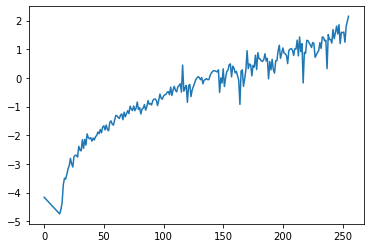

In [267]:
path = './data/images2'

# BGR Images
images = imread(path)
shutter_speed = np.log([32, 16, 8, 4, 2, 1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024])

P = len(images)

indices = indices_sampling(images, size=200)


# Sampling images' pixel value in a (3 x N x P) form
Z = images.transpose(3, 1, 2, 0).reshape(3, -1, P)[:, indices]

ge, ge2 = [], []
for i in range(3):
    ge.append(debevec(Z[i], shutter_speed, 0.1, get_windows()))
g, e = ge[2]
plt.plot(np.arange(256),g)
plt.show()

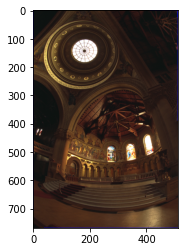

In [13]:
plt.imshow(images[5][:, :, ::-1])